In [1]:
!pip install git+https://github.com/octheo/futur.git@dev

  Cloning https://github.com/octheo/futur.git (to revision dev) to /tmp/pip-req-build-lz7x49b4
  Running command git clone --filter=blob:none --quiet https://github.com/octheo/futur.git /tmp/pip-req-build-lz7x49b4
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/octheo/futur.git to commit eb017fdf8e9f9991ce6c55e36261ba8ce9256182
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.9 MB/s eta 0:00:00
  Created wheel for thor: filename=thor-0.1-py3-none-any.whl size=7336 sha256=aff887fd30bee133d760145022580a811a6c1ecb2437838e9d099a01ed457d44
  Stored in directory: /tmp/pip-ephem-wheel-cache-fr2u95it/wheels/78/85/f5/44e9591c3fad8fd67121e7084e12ff682a870e8784c3c8ae2e
Successfully built thor


In [2]:
import os
import re
import glob
import math

import wandb
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch
import torch.nn.init as init
import torch.optim as optim
from transformers import ViTModel, ViTFeatureExtractor, ViTImageProcessor, ViTForImageClassification

from thor.splitters import supervised_AD as SAD
from thor.trainers import trainers, metrics
from thor.trainers import loss
from thor.datasets import mvtech

In [3]:
wandb_key = "01a878e22f13a8eeeddc5278818a41e2a4e85e64"

In [4]:
dataset_path = "/kaggle/input/mvtech-anomaly-detection/mvtec_anomaly_detection"
base_directory = dataset_path

In [5]:
pattern = r'^(?!.*\.).*$' # Filter txt files
classes = [item for item in os.listdir(base_directory) if re.match(pattern, item)]
classes.sort()
print(classes)

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [6]:
split1 = SAD.MVTech_AD_supervised_split(base_directory, classes[5], train_split=1, val_split=0, dist_adjust=False, multiclass=False)
split2 = SAD.MVTech_AD_supervised_split(base_directory, classes[9], train_split=1, val_split=0, dist_adjust=False, multiclass=False)

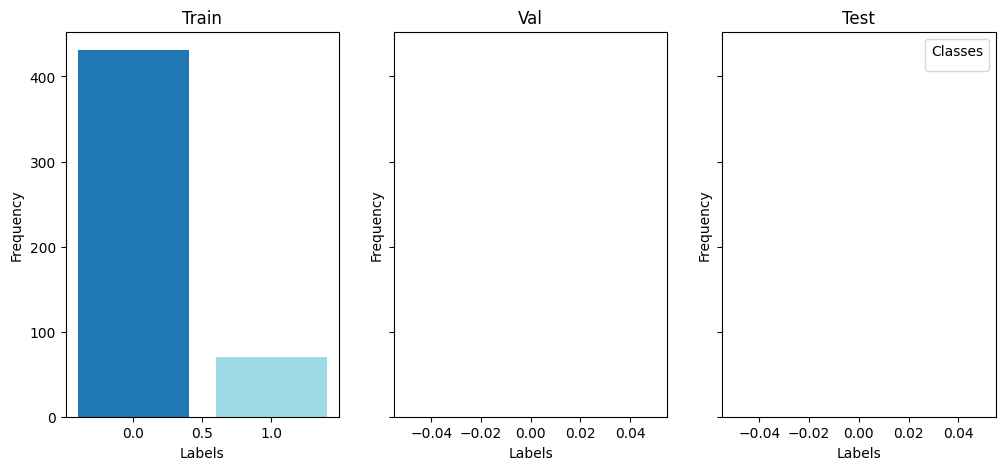

[[431, 70], [], []]

In [7]:
split1.plot_dist()

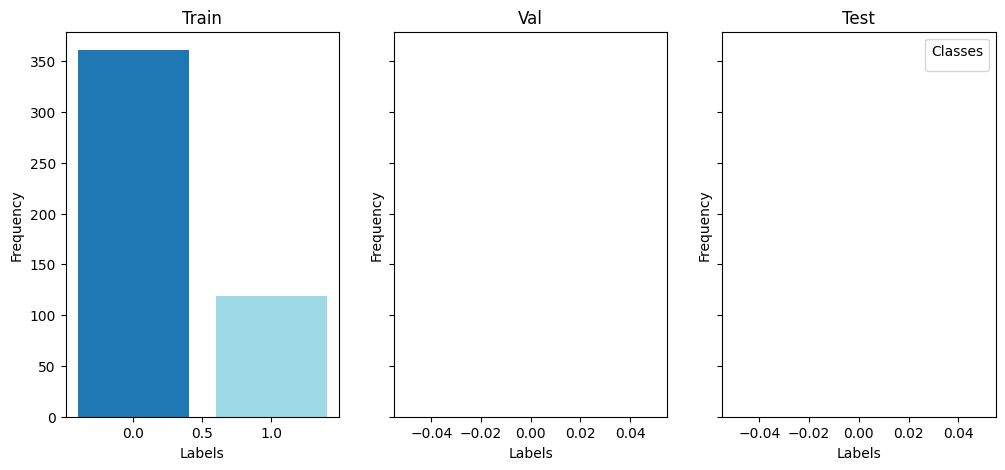

[[361, 119], [], []]

In [8]:
split2.plot_dist()

In [9]:
for i, sample in enumerate(split1.no_defect_samples):
    split1.no_defect_samples[i] = (sample, 0)

for i, sample in enumerate(split2.no_defect_samples):
    split2.no_defect_samples[i] = (sample, 1)

In [10]:
train = split1.no_defect_samples[:math.ceil(0.8*split1.nb_no_defect_samples)] + split2.no_defect_samples[:math.ceil(0.8*split2.nb_no_defect_samples)]
val = split1.no_defect_samples[math.ceil(0.8*split1.nb_no_defect_samples):math.ceil(0.9*split1.nb_no_defect_samples)] + \
       split2.no_defect_samples[math.ceil(0.8*split2.nb_no_defect_samples):math.ceil(0.9*split2.nb_no_defect_samples)]
test = split1.no_defect_samples[math.ceil(0.9*split1.nb_no_defect_samples):] + split2.no_defect_samples[math.ceil(0.9*split2.nb_no_defect_samples):]

In [11]:
train_transform = transforms.Compose([transforms.Resize(size=(500,500)),
                                     transforms.ToTensor()])

In [12]:
conf = {
    "WandB-activated": True,
    
    "training_class": 'test',
    "model": "efficientNetV2-S",
    "fine-tuned": False,
    "cls_head": "linear",

    "dropout": 0,
    "batch_size" : 32,
    "epochs" : 2,
    "Learning rate" : 1e-4,
    "L2 regularization weight": 0,
    
    'img_size': (512, 512),
    'loss': 'CrossEntropy',
    'metrics': ["f1", "precision", "recall"]
}

In [13]:
datasets = [mvtech.MVTechDataset_cls(split, transform=train_transform) for split in (train, val, test)]
dataloaders = [DataLoader(dataset, batch_size=conf["batch_size"], shuffle=True) for dataset in datasets]

In [14]:
selected_metrics = conf["metrics"]
base_model = models.efficientnet_v2_s(weights='DEFAULT')

num_features = base_model.classifier[-1].in_features
num_classes = 2
base_model.classifier = torch.nn.Sequential(torch.nn.Linear(num_features, num_classes))
                                            
optimizer = optim.Adam(base_model.classifier.parameters())
m = metrics.ClassificationMetrics(num_classes, selected_metrics)
l = loss.ClassificationLoss("CE")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 217MB/s]


In [15]:
if conf["WandB-activated"]:
    wandb.login(key=wandb_key)
    
    run = wandb.init(
        project="Classification",
        config=conf
    )

    model_artifact = wandb.Artifact("efficientNetV2-S", 
                                    type="model",
                                    description="Base training",
                                    metadata=conf
                                   )

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: theomoreau-thor (theomoreau-thor-octo-technology). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [16]:
trainer = trainers.CNNTrainer(optimizer, l, m)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in base_model.parameters():
    param.requires_grad = False

for param in base_model.classifier.parameters():
    param.requires_grad = True

save_path = "/kaggle/working/model.pth"
trainer.train(base_model, conf["epochs"], dataloaders[0], dataloaders[1], num_classes, device, save_path=save_path, wandb_run=run, model_artifact=model_artifact)
trainer.validate_model(base_model, dataloaders[2], num_classes, device, run, log_images=True)

Metric computation: 100%|██████████| 3/3 [00:12<00:00,  4.29s/Metric]


train loss: 0.004895322416958056, val loss: 0.023821182548999786


Metric computation: 100%|██████████| 3/3 [00:12<00:00,  4.21s/Metric]


train loss: 0.0015559483711656771, val loss: 0.00608594948425889


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
Metric computation: 100%|██████████| 3/3 [00:12<00:00,  4.18s/Metric]


In [17]:
wandb.finish()

avg_train_loss,█▁
avg_val_loss,█▁
train_f1,▁▁
train_loss,█▇▆▅▅▄▃▄▃▃▅▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▁▁
train_recall,▁▁
val_f1,▁▁
val_loss,▇▆█▁▁▁
val_precision,▁▁
val_recall,▁▁
avg_train_loss,0.00156
